# Barren Plateaus問題

Barren Plateau問題とは、  
量子ニューラルネットワークにおいてパラメータがランダムに初期化された場合、  
量子ビットや量子回路の深さの増加に伴い勾配が消失して学習が停滞してしまう現象のこと。

本notebookではランダムに初期化されたパラメータを持つ量子ニューラルネットワークにおいて、  
量子ビット数の増加に伴って勾配が消失することをシミュレータ上で検証する。

In [27]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.opflow import StateFn, PauliSumOp, Gradient

# ランダム回路の生成


例としてパラメータ1つの量子回路で、そのほかはランダムに初期化されている回転ゲートを含む回路を実装する。

In [28]:
# def generate_random_qnn(qubits, symbol, depth):
#     """Generate random QNN's with the same structure from McClean et al."""
#     circuit = QuantumCircuit(qubits)
#     for qubit in range(qubits):
#         circuit.ry(np.pi / 4.0, qubit)

#     for d in range(depth):
#         # Add a series of single qubit rotations.
#         for qubit in range(qubits):
#             random_n = np.random.uniform()
#             random_rot = np.random.uniform() * 2.0 * np.pi if qubit != 0 or d != 0 else symbol
#             circuit.rz(random_rot, qubit)
#             if random_n > 2. / 3.:
#                 # Add a Z.
#                 circuit.rz(random_rot, qubit)
#             elif random_n > 1. / 3.:
#                 # Add a Y.
#                 circuit.ry(random_rot, qubit)
#             else:
#                 # Add a X.
#                 circuit.rx(random_rot, qubit)

#         # Add CZ ladder.
#         for src, dest in zip(range(qubits), range(qubits)[1:]):
#             circuit.cz(src, dest)

#     return circuit

In [29]:
# 生成される回路の確認(例:3量子ビット)
# qc_test = generate_random_qnn(3, Parameter('theta'), 2)
# qc_test.draw('mpl')

In [30]:
def generate_real_amplitude_qnn(qubits, symbol, depth):
    """Generate random QNN's with the same structure from McClean et al."""
    circuit = QuantumCircuit(qubits)

    for d in range(depth):
        for qubit in range(qubits):
            random_rot = np.random.uniform() * 2.0 * np.pi if qubit != 0 or d != 0 else symbol
            circuit.ry(random_rot, qubit)
        for control in range(qubits-1):
            for target in range(control+1, qubits):
                circuit.cx(control, target) 

    return circuit

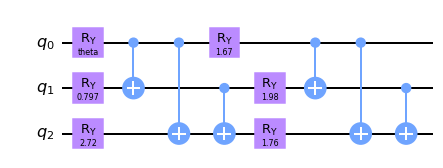

In [31]:
# 生成される回路の確認(例:3量子ビット)
qc_test = generate_real_amplitude_qnn(3, Parameter('theta'), 2)
qc_test.draw('mpl')

In [32]:
# 与えられた量子回路と演算子から期待値の勾配を求める関数を定義
def process_batch(circuits, H):
    grads = []
    for qc in circuits:
        qc_sfn = StateFn(qc)
        op = ~H @ qc_sfn

        weights = np.random.rand(qc.num_parameters)
        qc_params = qc.parameters.data
        param_dict = dict(zip(qc_params, weights))
        
        # パラメータシフト法で演算子の期待値に対するパラメータ微分を計算
        state_grad = Gradient(grad_method="param_shift").convert(operator=op, params=qc_params)
        grad = state_grad.assign_parameters(param_dict).eval()
        grads.append(np.array(grad).real[0])
    grad_var = np.var(grads)
    return grad_var

# 実行
注意：30分ほどかかります

量子ビットの数が増加するにつれて勾配の分散が減少しており、勾配が消失していることがわかる。

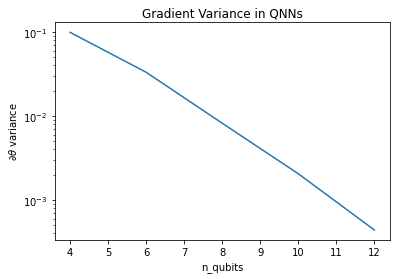

In [33]:
from qiskit_machine_learning.neural_networks import TwoLayerQNN

n_qubits = [2 * i for i in range(2, 7)]  # Ranges studied in paper are between 2 and 24.
depth = 50  # Ranges studied in paper are between 50 and 500.
n_circuits = 200
theta_var = []

for n in n_qubits:
    # Generate the random circuits and observable for the given n.
    symbol = Parameter('theta')
    circuits = [
        # generate_random_qnn(n, symbol, depth) for _ in range(n_circuits)
        real_amplitude_qnn(n, symbol, depth) for _ in range(n_circuits)
    ]
    H = StateFn(PauliSumOp.from_list([('Z', 1.0), ('X', 1.0)]))
    theta_var.append(process_batch(circuits, H))

plt.semilogy(n_qubits, theta_var)
plt.title('Gradient Variance in QNNs')
plt.xlabel('n_qubits')
plt.ylabel('$\\partial \\theta$ variance')
plt.show()

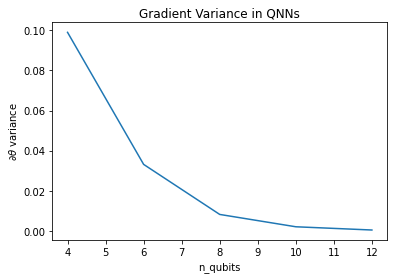

In [34]:
# 対数表示でないver
plt.plot(n_qubits, theta_var)
plt.title('Gradient Variance in QNNs')
plt.xlabel('n_qubits')
plt.ylabel('$\\partial \\theta$ variance')
plt.show()

## reference

- https://www.tensorflow.org/quantum/tutorials/barren_plateaus
- https://www.nature.com/articles/s41467-018-07090-4.pdf
- https://blog.tensorflow.org/2020/08/layerwise-learning-for-quantum-neural-networks.html

In [35]:
import qiskit.tools.jupyter
%qiskit_version_table